In [14]:
import pandas as pd
import requests
import random
import time
import matplotlib.pyplot as plt

In [15]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0",
    "Accept-Language": 'en-US,en;q=0.9',
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://tiki.vn/",
    "From": "",
    "af-ac-enc-dat": "",
    "x-api-source": "pc"
}

### EXTRACT SUB CATEGORY

In [16]:
URL = "https://api.tiki.vn/raiden/v2/menu-config?platform=desktop"
response = requests.get(URL, headers=HEADERS)
time.sleep(random.uniform(3.2, 8.7))
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to fetch data:", response.status_code)
    
group = data["menu_block"]["items"]
group_list = []
for group in group:
    link = group["link"]
    group_id = link.split("/")[-1][1:]
    text = group["text"]
    
    if group_id in ["1846", "1789"]:
        group_list.append([group_id, text])

group = pd.DataFrame(group_list, columns=["GroupID", "Name"])

In [17]:
category_list = []
for group_id, group_name in zip(group["GroupID"], group["Name"]):
    parent_url = f"https://tiki.vn/api/v2/categories?parent_id={group_id}"
    parent_response = requests.get(parent_url, headers=HEADERS)
    time.sleep(random.uniform(3.2, 8.7))
    if parent_response.status_code == 200:
        parent_data = parent_response.json()
        if not parent_data["data"]:
            category_list.append([group_id, group_name, None, None, None, None, None, None])
        else:
            for parent_category in parent_data["data"]:
                parent_id = parent_category["id"]
                parent_name = parent_category["name"]
                
                child_url = f"https://tiki.vn/api/v2/categories?parent_id={parent_id}"
                child_response = requests.get(child_url, headers=HEADERS)
                time.sleep(random.uniform(3.2, 8.7))
                
                if child_response.status_code == 200:
                    child_data = child_response.json()
                    if not child_data["data"]:
                        category_list.append([group_id, group_name, parent_id, parent_name, None, None, None, None])
                    else:
                        for child_category in child_data["data"]:
                            child_id = child_category["id"]
                            child_name = child_category["name"]
                            
                            type_url = f"https://tiki.vn/api/v2/categories?parent_id={child_id}"
                            type_response = requests.get(type_url, headers=HEADERS)
                            time.sleep(random.uniform(3.2, 8.7))
                            
                            if type_response.status_code == 200:
                                type_data = type_response.json()
                                if type_data["data"]:
                                    for type_item in type_data["data"]:
                                        type_id = type_item.get("id")
                                        type_name = type_item.get("name")
                                        category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, type_id, type_name])
                                else:
                                    category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, None, None])

category_df = pd.DataFrame(category_list, columns=["GroupID", "GroupName", "MasterCategoryID", "MasterCategoryName", "CategoryID", "CategoryName", "SubCategoryID", "SubCategoryName"])

In [18]:
def remove_single_category(df):
    # Group the DataFrame by MasterCategoryID and count the unique CategoryID values
    category_counts = df.groupby('MasterCategoryID')['CategoryID'].nunique()
    
    # Create a mask for MasterCategoryIDs with only one CategoryID
    single_category_mask = category_counts == 1
    
    # Drop the CategoryID and CategoryName columns for rows where there is only one CategoryID
    df.loc[df['MasterCategoryID'].isin(single_category_mask[single_category_mask].index), ['CategoryID', 'CategoryName']] = [None, None]
    
    return df
  
cleaned_df = remove_single_category(category_df)

def transform_category(row):
    # Handle MasterCategory and Category
    if pd.isna(row['CategoryID']):
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['MasterCategoryID']
        category_name = row['MasterCategoryName']
        is_category = 0
    else:
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['CategoryID']
        category_name = row['CategoryName']
        is_category = 1

    # Handle SubCategory
    if pd.isna(row['SubCategoryID']):
        sub_category_id = category_id
        sub_category_name = category_name
        is_sub_category = 0
    else:
        sub_category_id = row['SubCategoryID']
        sub_category_name = row['SubCategoryName']
        is_sub_category = 1

    return pd.Series([
        master_category_id, master_category_name, category_id, category_name,
        is_category, sub_category_id, sub_category_name, is_sub_category
    ])
    
category_df[['MasterCategoryID', 'MasterCategoryName', 'CategoryID', 'CategoryName',
             'isCategory', 'SubCategoryID', 'SubCategoryName', 'isSubCategory']] = category_df.apply(transform_category, axis=1, result_type='expand')

In [19]:
category_df["GroupID"] = category_df["GroupID"].astype(int)
category_df["MasterCategoryID"] = category_df["MasterCategoryID"].astype(int)
category_df["CategoryID"] = category_df["CategoryID"].astype(int)
category_df["SubCategoryID"] = category_df["SubCategoryID"].astype(int)


master_category = category_df[["MasterCategoryID", "GroupID", "MasterCategoryName"]].drop_duplicates()
master_category = master_category.rename(columns={"MasterCategoryName": "Name"})

category = category_df[["CategoryID", "MasterCategoryID", "CategoryName", "isCategory"]].drop_duplicates()
category = category.rename(columns={"CategoryName": "Name"})

sub_category = category_df[["SubCategoryID", "CategoryID", "SubCategoryName", "isSubCategory"]].drop_duplicates()
sub_category = sub_category.rename(columns={"SubCategoryName": "Name"})

In [21]:
def retrieve_product_ids(sub_category_id):
    base_url = "https://tiki.vn/api/personalish/v1/blocks/listings"
    PARAMS = {"category": sub_category_id, "page": 1}
    response = requests.get(base_url, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 8.7))
    data = response.json()
    total_page = data["paging"]["last_page"]

    # Fetch data from each page
    product_data = []
    for page in range(1, total_page + 1):
        PARAMS = {"category": sub_category_id, "page": page}
        response = requests.get(base_url, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 8.7))
        data = response.json()
        for item in data["data"]:
            product_id = item["id"]
            brand_name = item.get("brand_name", None)  # Use .get() with a default value in case brand_name is missing
            product_data.append({"product_id": product_id, "brand_name": brand_name})

    return product_data

product_df = []

for sub_category_id in sub_category["SubCategoryID"]:
    product_data = retrieve_product_ids(sub_category_id)
    for product in product_data:
        product_df.append([sub_category_id, product["product_id"], product["brand_name"]])
    
product_df = pd.DataFrame(product_df, columns=["SubCategoryID", "ProductID", "BrandName"])

In [25]:
# Save it to CSV
product_df

,SubCategoryID,ProductID,BrandName
0,1795,184036446,Apple
1,1795,184059211,Apple
2,1795,57809866,Xiaomi
3,1795,120295859,Nokia
4,1795,123345348,Apple
...,...,...,...
23757,28926,249024285,OEM
23758,28926,204425773,OEM
23759,28926,13429081,OEM
23760,28926,72843893,OEM


In [33]:
# Count the number of ProductID by BrandName
brand_counts = product_df["BrandName"].value_counts()
brand_counts.head(10)

BrandName
OEM            7635
MISUFUJl       1839
HI PC          1748
UGREEN          578
HP              501
Dell            334
Samsung         311
Tenda           298
RONALD JACK     290
TP-Link         241
Name: count, dtype: int64

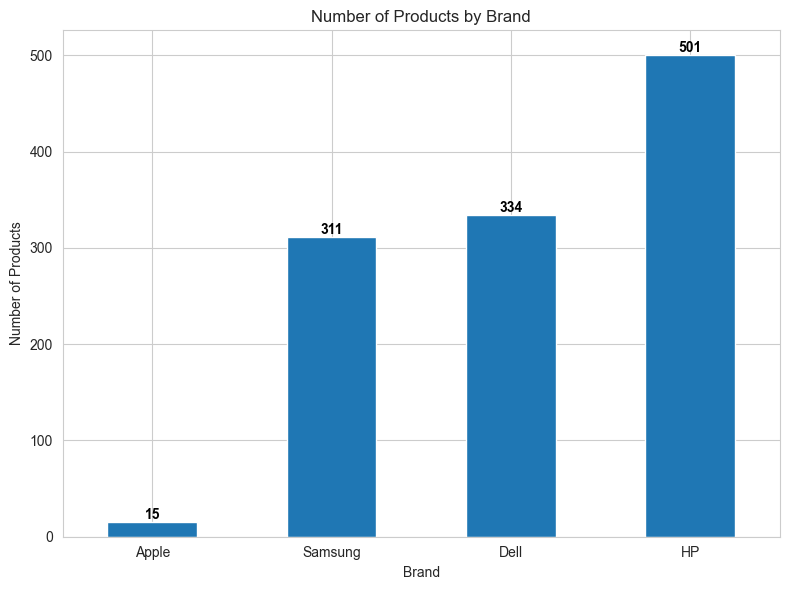

In [38]:
brands = ['Apple', 'Samsung', 'Dell', 'HP']
brand_counts = brand_counts[brands]

fig, ax = plt.subplots(figsize=(8, 6))
brand_counts.plot(kind='bar', ax=ax)

for i, v in enumerate(brand_counts):
    ax.text(i, v, str(v), color='black', fontweight='bold', horizontalalignment='center', verticalalignment='bottom')

plt.title('Number of Products by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Products')

plt.xticks(range(len(brands)), brands, rotation=0)

plt.tight_layout()
plt.show()

In [39]:
filtered_df = product_df[product_df['BrandName'].isin(brands)]
filtered_df

,SubCategoryID,ProductID,BrandName
0,1795,184036446,Apple
1,1795,184059211,Apple
4,1795,123345348,Apple
15,1795,197966909,Samsung
28,1795,213931247,Samsung
...,...,...,...
17013,12298,16613522,Samsung
17020,12298,72288260,Samsung
17083,12298,262456040,Samsung
17109,12298,263394064,HP


In [40]:
filtered_df.to_csv("temp.csv", index=False)

### RETRIEVE PRODUCT DATA

In [42]:
product_data_list = []

for _, row in filtered_df.iterrows():
    sub_category_id = row['SubCategoryID']
    product_id = row['ProductID']

    URL = f"https://tiki.vn/api/v2/products/{product_id}"
    PARAMS = {}

    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 4.7))
    
    data = response.json()

    product_data = {
        'product_id': data['id'],
        'product_name': data.get('name', None),
        'product_url': data.get('short_url', None),
        'pricing_current': data.get('price', None),
        'pricing_original': data.get('original_price', None),
        'product_image_url': data.get('thumbnail_url', None),
        'inventory_status': data.get('inventory_status', None),
        'inventory_type': data.get('inventory_type', None),
        'created_date': data.get('day_ago_created', None),
        'quantity_sold': data.get('all_time_quantity_sold', None),
        'brand_id': data.get('brand', {}).get('id', None),
        'brand_name': data.get('brand', {}).get('name', None),
        'brand_slug': data.get('brand', {}).get('slug', None),
        'seller_id': data.get('current_seller', {}).get('id', 0) if data.get('current_seller') else 0,
        'seller_name': data.get('current_seller', {}).get('name', 0) if data.get('current_seller') else 0,
        'seller_link': data.get('current_seller', {}).get('link', 0) if data.get('current_seller') else 0,
        'seller_image_url': data.get('current_seller', {}).get('logo', 0) if data.get('current_seller') else 0,
        'category_id': data['categories']['id'] if data['categories']['is_leaf'] else data['breadcrumbs'][-2]['category_id'],
        'sub_category_id': sub_category_id,
        'brand_name': row['BrandName']
    }

    product_data_list.append(product_data)

print(f"Success fetching data for {len(product_data_list)} products")
product_df = pd.DataFrame(product_data_list, columns=['product_id', 'product_name', 'product_url', 'pricing_current', 'pricing_original', 'product_image_url', 'inventory_status', 'inventory_type', 'created_date', 'quantity_sold', 'brand_id', 'brand_name', 'brand_slug', 'seller_id', 'seller_name', 'seller_link', 'seller_image_url', 'category_id', 'sub_category_id', 'brand_name'])
product_df.to_csv("product_data.csv", index=False, encoding='utf-8-sig')
product_df.head(10)

In [ ]:
# URL = f"https://tiki.vn/api/v2/products/{product_id}"
# PARAMS = {
# }

# response = requests.get(URL, headers=HEADERS, params=PARAMS)
# time.sleep(random.uniform(3.2, 4.7))

# data = response.json()

# product_data = {
#     'product_id': data['id'],
#     'product_name': data.get('name', None),
#     'product_url': data.get('short_url', None),
#     'pricing_current': data.get('price', None),
#     'pricing_original': data.get('original_price', None),
#     'product_image_url': data.get('thumbnail_url', None),
#     'inventory_status': data.get('inventory_status', None),
#     'inventory_type': data.get('inventory_type', None),
#     'created_date': data.get('day_ago_created', None),
#     'quantity_sold': data.get('all_time_quantity_sold', None),
#     'brand_id': data.get('brand', {}).get('id', None),
#     'brand_name': data.get('brand', {}).get('name', None),
#     'brand_slug': data.get('brand', {}).get('slug', None),
#     'seller_id': data.get('current_seller', {}).get('id', 0) if data.get('current_seller') else 0,
#     'seller_name': data.get('current_seller', {}).get('name', 0) if data.get('current_seller') else 0,
#     'seller_link': data.get('current_seller', {}).get('link', 0) if data.get('current_seller') else 0,
#     'seller_image_url': data.get('current_seller', {}).get('logo', 0) if data.get('current_seller') else 0
# }

# # sub_category ID
# if data['categories']['is_leaf']:
#     category_id = data['categories']['id']
# else:
#     category_id = data['breadcrumbs'][-2]['category_id']
# product_data['category_id'] = category_id

# product_df = pd.DataFrame([product_data],columns= ['product_id', 'product_name', 'product_url', 'pricing_current', 'pricing_original', 'product_image_url', 'inventory_status', 'inventory_type', 'created_date', 'quantity_sold', 'brand_id', 'brand_name', 'brand_slug', 'seller_id', 'seller_name', 'seller_link', 'seller_image_url', 'category_id'])
# product_df

,product_id,product_name,product_url,pricing_current,pricing_original,product_image_url,inventory_status,inventory_type,created_date,quantity_sold,brand_id,brand_name,brand_slug,seller_id,seller_name,seller_link,seller_image_url,category_id
0,184036446,Apple iPhone 11,https://tiki.vn/product-p184036446.html?spid=3...,8650000,12990000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,instock,707,13990,17827,Apple,apple,1,Tiki Trading,https://tiki.vn/cua-hang/tiki-trading,21/ce/5c/b52d0b8576680dc3666474ae31b091ec.jpg,1795


### RETRIEVE FEEDBACK DATA

In [ ]:
feedback_data_list = []

for _, row in filtered_df.iterrows():
    sub_category_id = row['SubCategoryID']
    product_id = row['ProductID']

    URL = "https://tiki.vn/api/v2/reviews"
    PARAMS = {"limit": 20, "spid": sub_category_id, "product_id": product_id}

    # Get the total number of pages
    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    data = response.json()
    total_pages = data.get("paging", {}).get("last_page", 1)

    # Fetch data from each page
    for page in range(1, total_pages + 1):
        PARAMS["page"] = page
        response = requests.get(URL, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 4.7))
        data = response.json()

        stars = data.get("stars", {})
        OneStarCount = stars.get("1", {}).get("count", 0)
        TwoStarCount = stars.get("2", {}).get("count", 0)
        ThreeStarCount = stars.get("3", {}).get("count", 0)
        FourStarCount = stars.get("4", {}).get("count", 0)
        FiveStarCount = stars.get("5", {}).get("count", 0)
        reviews_count = data.get("reviews_count", 0)
        review_data = data.get("data", [])

        for review in review_data:
            review_id = review.get("id")
            review_title = review.get("title")
            review_content = review.get("content")
            review_upvote = review.get("thank_count", 0)
            review_rating = review.get("rating")
            review_created_at = review.get("created_at")
            reviewer = review.get("created_by", {})
            user_id = reviewer.get("id")
            username = reviewer.get("name")
            joined_time = reviewer.get("created_time")
            total_reviews = reviewer.get("contribute_info", {}).get("summary", {}).get("total_review", 0)
            total_upvotes = reviewer.get("contribute_info", {}).get("summary", {}).get("total_thank", 0)

            feedback_data_list.append([OneStarCount, TwoStarCount, ThreeStarCount, FourStarCount, FiveStarCount, reviews_count, review_id, review_title, review_content, review_upvote, review_rating, review_created_at, user_id, username, joined_time, total_reviews, total_upvotes])


print(f"Success fetching data for {len(feedback_data_list)} feedbacks")
feedback_df = pd.DataFrame(feedback_data_list, columns=["OneStarCount", "TwoStarCount", "ThreeStarCount", "FourStarCount", "FiveStarCount", "reviews_count", "review_id", "review_title", "review_content", "review_upvote", "review_rating", "review_created_at", "user_id", "username", "joined_time", "total_reviews", "total_upvotes"])
product_df.to_csv("feedback_data.csv", index=False, encoding='utf-8-sig')
product_df.head(10)

In [ ]:
# URL = "https://tiki.vn/api/v2/reviews"
# PARAMS = {"limit": 20, 
#           "spid": sub_category, 
#           "product_id": product_id}

# feedback_data = []

# # Get the total number of pages
# response = requests.get(URL, headers=HEADERS, params=PARAMS)
# data = response.json()
# total_pages = data.get("paging", {}).get("last_page", 1)

# # Fetch data from each page
# for page in range(1, total_pages + 1):
#     PARAMS["page"] = page
#     response = requests.get(URL, headers=HEADERS, params=PARAMS)
#     time.sleep(random.uniform(3.2, 4.7))
#     data = response.json()

#     stars = data.get("stars", {})
#     OneStarCount = stars.get("1", {}).get("count", 0)
#     TwoStarCount = stars.get("2", {}).get("count", 0)
#     ThreeStarCount = stars.get("3", {}).get("count", 0)
#     FourStarCount = stars.get("4", {}).get("count", 0)
#     FiveStarCount = stars.get("5", {}).get("count", 0)
#     reviews_count = data.get("reviews_count", 0)

#     review_data = data.get("data", [])
#     for review in review_data:
#         review_id = review.get("id")
#         review_title = review.get("title")
#         review_content = review.get("content")
#         review_upvote = review.get("thank_count", 0)
#         review_rating = review.get("rating")
#         review_created_at = review.get("created_at")
#         reviewer = review.get("created_by", {})
#         user_id = reviewer.get("id")
#         username = reviewer.get("name")
#         joined_time = reviewer.get("created_time")
#         total_reviews = reviewer.get("contribute_info", {}).get("summary", {}).get("total_review", 0)
#         total_upvotes = reviewer.get("contribute_info", {}).get("summary", {}).get("total_thank", 0)
#         feedback_data.append([OneStarCount, TwoStarCount, ThreeStarCount, FourStarCount, FiveStarCount, reviews_count, review_id, review_title, review_content, review_upvote, review_rating, review_created_at, user_id, username, joined_time, total_reviews, total_upvotes])

# feedback_df = pd.DataFrame(feedback_data, columns=["OneStarCount", "TwoStarCount", "ThreeStarCount", "FourStarCount", "FiveStarCount", "reviews_count", "review_id", "review_title", "review_content", "review_upvote", "review_rating", "review_created_at", "user_id", "username", "joined_time", "total_reviews", "total_upvotes"])
# feedback_df

,OneStarCount,TwoStarCount,ThreeStarCount,FourStarCount,FiveStarCount,reviews_count,review_id,review_title,review_content,review_upvote,review_rating,review_created_at,user_id,username,joined_time,total_reviews,total_upvotes
0,61,13,32,183,2700,2989,19708302,Cực kì hài lòng,Đợt này mua tặng 2 cây trắng đen nhưng quên ch...,3,5,1704256818,5178168,Đại Hồng Bào,2017-04-10 14:05:29,273,369
1,61,13,32,183,2700,2989,19708307,Cực kì hài lòng,Đợt này mua tặng 2 cây trắng (giao từ Hanoi) đ...,2,5,1704256916,5178168,Đại Hồng Bào,2017-04-10 14:05:29,273,369
2,61,13,32,183,2700,2989,17356319,Cực kì hài lòng,"5* cho máy còn nguyên seal, hàng chính hãng VN...",184,5,1660043992,945720,muasach,2015-11-07 17:41:14,154,234
3,61,13,32,183,2700,2989,19694107,Rất không hài lòng,"Mua xài mới có 1 ngày mà đã lỗi, có cuộc gọi t...",1,1,1703434010,15052027,TRAN THUY,2019-11-20 17:08:29,39,1
4,61,13,32,183,2700,2989,18794713,Cực kì hài lòng,Chất lượng sản phẩm của Shop rất tốt đẹp full ...,20,5,1676287655,28830179,Minh Phương,2023-02-13 13:39:52,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,61,13,32,183,2700,2989,2804952,Ip11 màu đen,good,0,5,1577876061,335589,Huỳnh Hưng,2014-04-22 16:58:35,31,4
2989,61,13,32,183,2700,2989,17349937,Rất không hài lòng,(*) Đánh giá không tính điểm\nSáng mua giá 10....,0,1,1660014909,5982584,Lê Nghĩa,2017-10-28 11:20:36,58,6
2990,61,13,32,183,2700,2989,17371017,Rất không hài lòng,(*) Đánh giá không tính điểm\nTiki chăm sóc kh...,0,1,1660140662,15436788,QUYNH NGUYEN,2019-12-12 22:55:05,81,5
2991,61,13,32,183,2700,2989,17952552,Rất không hài lòng,(*) Đánh giá không tính điểm\nThứ nhất: J&T là...,0,1,1665676499,533759,Chủ Lò,2015-01-10 17:35:21,57,40
